In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
from tqdm import tqdm
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix/psix/')
import psix

# Alternative splicing in mouse brain development

Here we analyse a smart-seq2 dataset from [Tiklova et al (2019)](https://www.nature.com/articles/s41467-019-08453-1) that follows the development of brain neurons at different stages of development: E13.5, E15.5, E18.5, P0, P7, P15 and P90.

This dataset originally consists of 1699 cells. However, after quality control and normalization, we removed many cells that either had poor coverage, or that were found to be non-neural cells (mostly oligodendrocytes). This left a total of 1067 single neurons. After preprocessing, we observe a clear trajectory of neuron development in this dataset:

<img src="plots/PCA_neurogenesis.png">

## Identifying informative exons with Psix

[Psix](https://github.com/cfbuenabadn/psix) is an autocorrelation-inspired computational tool that identifies informative exons in single cells. In order to run, Psix requires three inputs:

* Alternative splicing rates, or $\Psi$, per exon per cell.
* mRNA counts per exon. The mRNAs that are *informative* about the splicing of the exon. 
* An **interpretable** cell-cell similarity metric to infer what cells are close or similar to each other. This can be a latent space from a dimensionality reduction process.

It is important that the dimensionality reduction map is interpretable, such as the result of PCA, ZINBWave or scVI. It is **not** recommended to run Psix on non-interpretable visualization manifolds such as tSNE or UMAP.

### Step 1: create Psix object and pre-process smart-seq data.

There are many approaches to estimating the exon $\Psi$ and mRNA counts matrices. Psix has a built-in functionality that can produce these two matrices from:
* A matrix of exon splice junctions
* Amatrix of constitutive splice junctions
* A matrix of TPM counts. 

You can get the matrices of exon and constitutive splice juntions directly from the output of STAR alignment using out pre-processing package [sc-splicing-tools](https://github.com/cfbuenabadn/sc_splicing_tools). Future versions of Psix and of sc-splicing-tools will handle a single splice junction counts file for both alternative exons and constitutive junctions.

This step will create a $\Psi$ per cell table, estimate the mRNAs per genes using the Census normalization, and estimate the mRNAs per exon by adjusting the reads by junction coverage.

In [2]:
psix_object = psix.Psix()
psix_object.process_smartseq(
        'data/preprocess/sj_counts.tab.gz',
        'data/preprocess/constitutive_introns.tab.gz',
        'data/preprocess/tpm.tab.gz',
        minJR = 1,
        minCell=1,
        min_observed = 0.25)

Obtaining psi tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 1067/1067 [00:45<00:00, 23.61it/s]


Successfully processed smart-seq data


### Step 2: Computing exon scores with Psix

Psix can be called to compute the scores for each exon. In order to do that, a cell metric has to be provided. Here we provide the PCA dimensionality reduction of the normalized data obtained in `data/preprocess/preprocess.ipynb`. For each cell, Psix will identify its closest k nearest neighbors and estimate its mean $\hat{\Psi}$. By default Psix works with 100 neighbors - since drop-outs are not informative for splicing, we use a larger number of neighbors than it is usually used for gene expression analysis.

Psix then estimates the probability of observing the $\hat{\Psi}$ of each cell, given the weighted mean $\hat{\Psi}$ of it's k-nearest neighbors, and compare it to the probability of the same observation given the mean $\hat{\Psi}$ of the entire cell population. This is based on the idea that informative exons are autocorrelated to cell identity in the cell-cell metric.

P-values are estimated with random permutations of the data. This is the most time consuming step, thus parallelizing is recommended.

In [3]:
psix_object.compute_psix_scores(latent='data/preprocess/pc2_rd.tab.gz', n_jobs=25, n_random_exons=2000)

  0%|          | 5/1067 [00:00<00:22, 46.61it/s]

cell-cell metric not found. Computing metric...
Obtaining cell-cell neighbors and weights


100%|██████████| 1067/1067 [00:22<00:00, 48.41it/s]

Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:16<00:00, 126.08it/s] 


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 25/25 [07:39<00:00, 18.37s/it]  


Successfully estimated p-values


We can see the results from Psix:

In [4]:
psix_results = psix_object.psix_results
psix_results.head()

,psix_score,pvals,qvals
Mapt_1,2.548385,0.0005,0.001889
Dbn1_1,2.267717,0.0005,0.001889
Ndrg4_1,2.214822,0.0005,0.001889
Mapt_3,1.887938,0.0005,0.001889
Gabrg2_1,1.835597,0.0005,0.001889


### Saving Psix results

Finally, we save our Psix object for later use. This way we can load the results without having to go through the calculations again.

In [5]:
psix_object.save_psix_object()

### Informative exons found by Psix

Here we visualize the exon scores obtained by Psix, vs the scores of the randomized exons that Psix used for significance estimation. We highlight the score of some exons associated to neurogenesis.

100%|██████████| 2087/2087 [00:12<00:00, 161.60it/s]


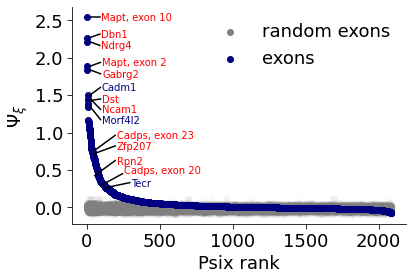

In [6]:
psix_results = psix_object.psix_results.copy()
psix_results['bins'] = ['']*2087

for mean in psix_object.bins.keys():
    for var in psix_object.bins[mean].keys():
        for exon in psix_object.bins[mean][var]:
            psix_results.loc[exon, 'bins'] = mean +'_' + var
            
fig = plt.figure()
ax  = plt.subplot(1,1,1)
i = 1

ax.scatter([100], [-0.05], c='gray', label='random exons')

for mean_var in tqdm(psix_results.sort_values('psix_score')[::-1].bins):
    mean = mean_var[:6]
    var = mean_var[7:]
    subset = np.random.choice(psix_object.random_scores[mean][var], 50, replace=False)
    ax.scatter([i]*50, subset, c='gray', alpha=0.02)
    i += 1


plt.text(100, psix_results.loc['Mapt_1'].psix_score-0.05, 'Mapt, exon 10', c='red')   
plt.plot([20, 90], [psix_results.loc['Mapt_1'].psix_score, psix_results.loc['Mapt_1'].psix_score],c='black')

plt.text(100, psix_results.loc['Ndrg4_1'].psix_score-0.1, 'Ndrg4', c='red')   
plt.plot([20, 90], [psix_results.loc['Ndrg4_1'].psix_score, psix_results.loc['Ndrg4_1'].psix_score-0.05],c='black')

plt.text(100, psix_results.loc['Dbn1_1'].psix_score, 'Dbn1', c='red')   
plt.plot([20, 90], [psix_results.loc['Dbn1_1'].psix_score, psix_results.loc['Dbn1_1'].psix_score+0.05],c='black')

plt.text(104, psix_results.loc['Mapt_3'].psix_score, 'Mapt, exon 2', c='red')    
plt.plot([24, 94], [psix_results.loc['Mapt_3'].psix_score, psix_results.loc['Mapt_3'].psix_score+0.05],c='black')

plt.text(105, psix_results.loc['Gabrg2_1'].psix_score-0.1, 'Gabrg2', c='red')   
plt.plot([25, 95], [psix_results.loc['Gabrg2_1'].psix_score, psix_results.loc['Gabrg2_1'].psix_score-0.05],c='black')

plt.text(104, psix_results.loc['Cadm1_10'].psix_score+0.05, 'Cadm1', c='navy')    
plt.plot([24, 94], [psix_results.loc['Cadm1_10'].psix_score, psix_results.loc['Cadm1_10'].psix_score+0.1],c='black')

plt.text(105, psix_results.loc['Dst_5'].psix_score-0.03, 'Dst', c='red')   
plt.plot([25, 95], [psix_results.loc['Dst_5'].psix_score, psix_results.loc['Dst_5'].psix_score+0.02],c='black')

plt.text(104, psix_results.loc['Ncam1_6'].psix_score-0.19, 'Ncam1', c='red')    
plt.plot([24, 94], [psix_results.loc['Ncam1_6'].psix_score, psix_results.loc['Ncam1_6'].psix_score-0.14],c='black')

plt.text(105, psix_results.loc['Morf4l2_7'].psix_score-0.22, 'Morf4l2', c='navy')   
plt.plot([25, 95], [psix_results.loc['Morf4l2_7'].psix_score, psix_results.loc['Morf4l2_7'].psix_score-0.17],c='black')

plt.text(305, psix_results.loc['Tecr_6'].psix_score+0.02, 'Tecr', c='navy')   
plt.plot([125, 295], [psix_results.loc['Tecr_6'].psix_score, psix_results.loc['Tecr_6'].psix_score+0.07],c='black')

plt.text(205, psix_results.loc['Rpn2_3'].psix_score+0.15, 'Rpn2', c='red')   
plt.plot([55, 195], [psix_results.loc['Rpn2_3'].psix_score, psix_results.loc['Rpn2_3'].psix_score+0.2],c='black')

plt.text(255, psix_results.loc['Cadps_2'].psix_score+0.15, 'Cadps, exon 20', c='red')   
plt.plot([105, 245], [psix_results.loc['Cadps_2'].psix_score, psix_results.loc['Cadps_2'].psix_score+0.15],c='black')

plt.text(205, psix_results.loc['Cadps_7'].psix_score+0.15, 'Cadps, exon 23', c='red')   
plt.plot([55, 195], [psix_results.loc['Cadps_7'].psix_score, psix_results.loc['Cadps_7'].psix_score+0.2],c='black')

plt.text(205, psix_results.loc['Zfp207_1'].psix_score+0.05, 'Zfp207', c='red')   
plt.plot([55, 195], [psix_results.loc['Zfp207_1'].psix_score, psix_results.loc['Zfp207_1'].psix_score+0.1],c='black')

ax.scatter(np.arange(1, len(psix_results.index)+1), psix_results.sort_values('psix_score')[::-1].psix_score, c = 'navy',
          label='exons')
    
plt.xlabel('Psix rank', fontsize=18)
plt.ylabel(r'$\Psi_{\xi}$', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.legend(frameon=False, fontsize=18)

plt.savefig('plots/psix_scores.png', bbox_inches='tight', res=100)
plt.savefig('plots/psix_scores.svg', bbox_inches='tight')
plt.savefig('plots/psix_scores.pdf', bbox_inches='tight')

## Modules of splicing co-regulation

The noisiness of scRNA-seq data makes the analysis of splicing co-regulation very difficult. Spatial autocorrelation methods like [Hotspot](https://www.biorxiv.org/content/10.1101/2020.02.06.937805v1) use the information from neighborhoods of cells to find modules of co-expression. Here we take advantage of Psix's calculation of the weighted mean of each cell's k-nearest neighbors to obtain a matrix of correlation between significant exons.

In [11]:
psix_object.compute_neighbors_psi()

slicing exons...


100%|██████████| 2087/2087 [00:05<00:00, 393.09it/s]

Successfully computed neighbors


We then use a modification of the UPGMA alogithm as implemented in Hotspot to estimate modules of co-spliced exons.

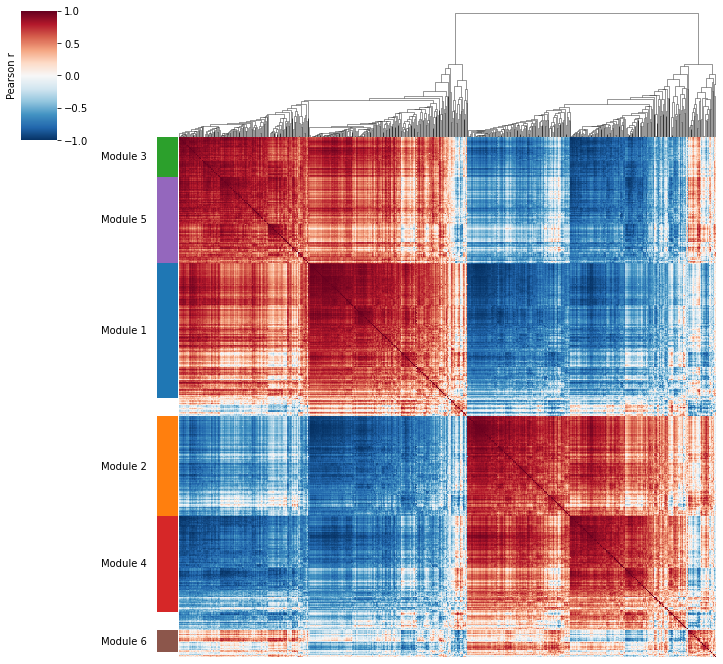

In [13]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/analysis_psix/utils/')
from misc_utils import *

background_psi = psix_object.adata.uns['neighbors_psi'].T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=30, fdr_threshold=None, z_threshold=0.3, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow[0], bwow[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False
)

We find that these modules are associated to temporal changes in splicing.

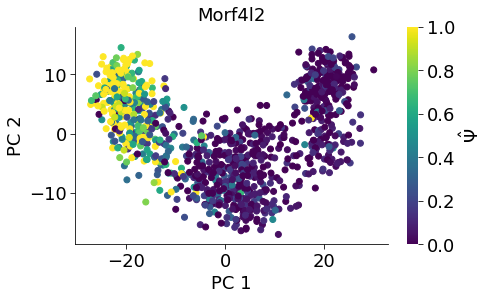

In [4]:
fig = plt.figure(figsize=(7, 4))
ax  = plt.subplot(1,1,1)
sc = ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                c=psix_object.adata.uns['psi']['Morf4l2_7'])
# cb = plt.colorbar(sc)
ax.tick_params(labelsize=18, length=5)
cb = plt.colorbar(sc, shrink = 1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.title('Morf4l2', fontsize=18)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



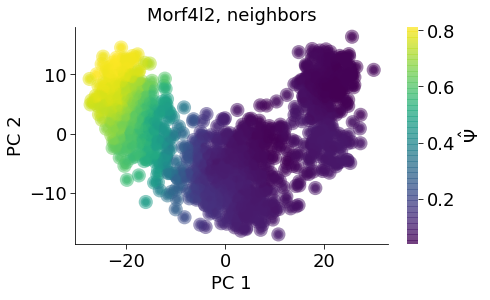

In [35]:
fig = plt.figure(figsize=(7, 4))
ax  = plt.subplot(1,1,1)
sc = ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                c=psix_object.adata.uns['neighbors_psi']['Morf4l2_7'], s=200, alpha=0.5, linewidth=0)

ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                c=psix_object.adata.uns['neighbors_psi']['Morf4l2_7'], s=100, alpha=0.5, linewidth=0)

ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                c=psix_object.adata.uns['neighbors_psi']['Morf4l2_7'], s=50, alpha=0.5, linewidth=0)

ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                c=psix_object.adata.uns['neighbors_psi']['Morf4l2_7'], s=25, alpha=0.1, linewidth=0)
# cb = plt.colorbar(sc)
ax.tick_params(labelsize=18, length=5)
cb = plt.colorbar(sc, shrink = 1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.title('Morf4l2, neighbors', fontsize=18)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



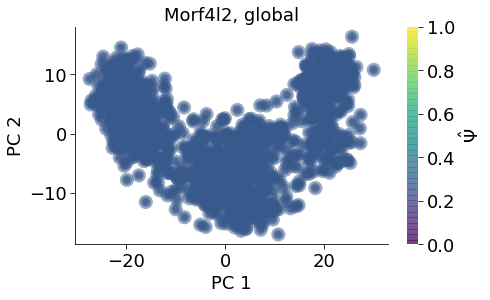

In [38]:
fig = plt.figure(figsize=(7, 4))
ax  = plt.subplot(1,1,1)
sc = ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                c=[psix_object.adata.uns['neighbors_psi']['Morf4l2_7'].mean()]*1067, s=200, alpha=0.5, linewidth=0, vmin=0, vmax=1)

ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                c=[psix_object.adata.uns['neighbors_psi']['Morf4l2_7'].mean()]*1067, s=100, alpha=0.5, linewidth=0, vmin=0, vmax=1)

ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                c=[psix_object.adata.uns['neighbors_psi']['Morf4l2_7'].mean()]*1067, s=50, alpha=0.5, linewidth=0, vmin=0, vmax=1)

ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                c=[psix_object.adata.uns['neighbors_psi']['Morf4l2_7'].mean()]*1067, s=25, alpha=0.1, linewidth=0, vmin=0, vmax=1)
# cb = plt.colorbar(sc)
ax.tick_params(labelsize=18, length=5)
cb = plt.colorbar(sc, shrink = 1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.title('Morf4l2, global', fontsize=18)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



In [34]:
psix_object.adata.uns['psi']['Morf4l2_7'].mean()

0.272141956891259

In [35]:
psix_object.adata.uns['psi']['Morf4l2_7'].mask(psix_object.adata.uns['mrna_per_event']['Morf4l2_7']<15).mean()

0.09765320092241861

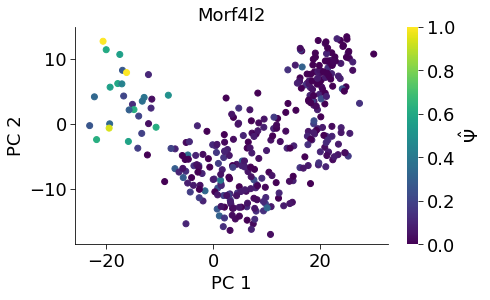

In [32]:
fig = plt.figure(figsize=(7, 4))
ax  = plt.subplot(1,1,1)
sc = ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                c=psix_object.adata.uns['psi']['Morf4l2_7'].mask(psix_object.adata.uns['mrna_per_event']['Morf4l2_7']<15))
# cb = plt.colorbar(sc)
ax.tick_params(labelsize=18, length=5)
cb = plt.colorbar(sc, shrink = 1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.title('Morf4l2', fontsize=18)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



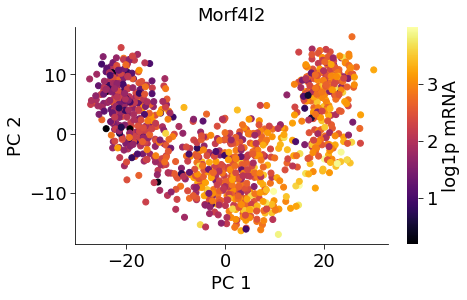

In [33]:
fig = plt.figure(figsize=(7, 4))
ax  = plt.subplot(1,1,1)
sc = ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                c=np.log1p(psix_object.adata.uns['mrna_per_event']['Morf4l2_7']), cmap='inferno')
# cb = plt.colorbar(sc)
ax.tick_params(labelsize=18, length=5)
cb = plt.colorbar(sc, shrink = 1)
cb.set_label(label='log1p mRNA',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.title('Morf4l2', fontsize=18)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



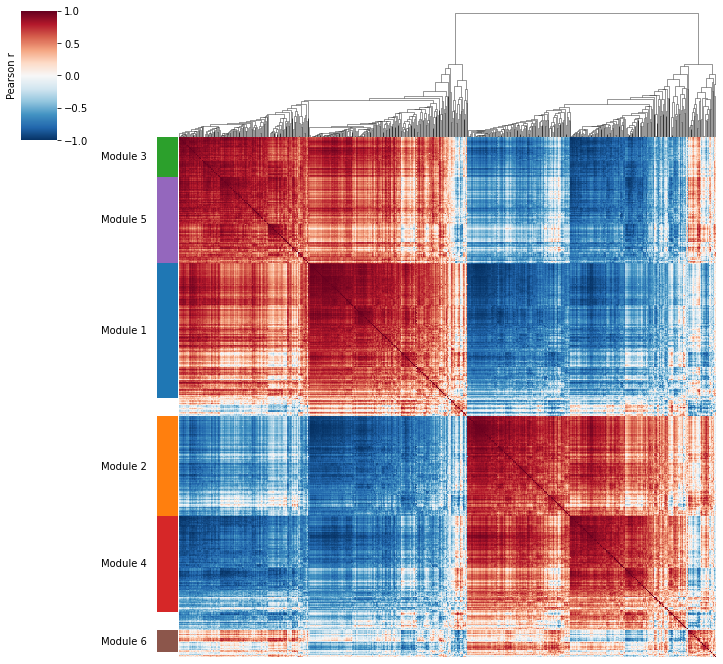

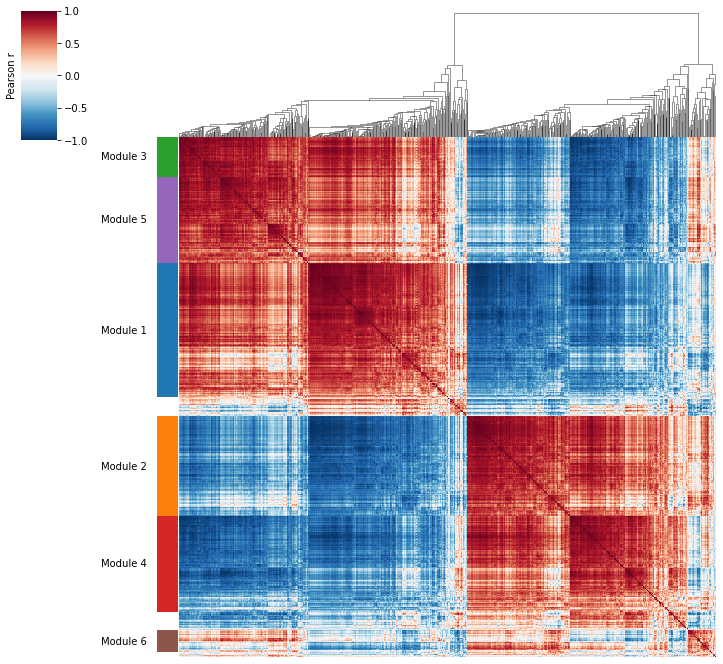

In [4]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix/utils')
import psix_functions as pr


sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/analysis_psix/utils/')
from misc_utils import *

from scipy.special import logit, expit
import hotspot

background_psi = psix_object.adata.uns['neighbors_psi'].T

psix_results = psix_object.psix_results
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index


bwow = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=30, fdr_threshold=None, z_threshold=0.3, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow[0], bwow[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False
)

In [6]:
len(exon_list)

710

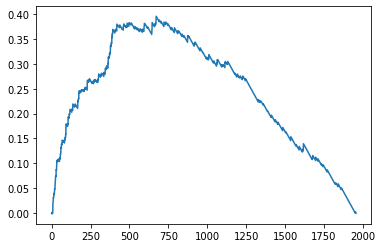

In [7]:
motif_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/meme_motifs/'
mouse_motifs_exons = pd.read_csv(motif_dir + 'mouse_rbp.exons.tab', sep='\t', index_col=0)
mouse_motifs_ase = pd.read_csv(motif_dir + 'mouse_rbp.ase.tab', sep='\t', index_col=0)

human_motifs_exons = pd.read_csv(motif_dir + 'human_rbp.exons.tab', sep='\t', index_col=0)
human_motifs_ase = pd.read_csv(motif_dir + 'human_rbp.ase.tab', sep='\t', index_col=0)

clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/'
mouse_clip_predicted = pd.read_csv(clip_dir + 'peaks_predicted_mRBP.tab', sep='\t', index_col=0)
mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags.tab', sep='\t', index_col=0)

mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova_hRBP/'
human_clip_predicted = pd.read_csv(clip_dir + 'peaks_predicted_hRBP.tab', sep='\t', index_col=0)

human_clip_predicted = (human_clip_predicted.loc[[x for x in human_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
human_clip_predicted.index= [x[:-3] for x in human_clip_predicted.index if x[-3:]=='_se']

clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/'

mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0)

mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']


mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0)
exon_lengths = pd.read_csv('~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/exon_lengths.tab', sep='\t',
                           index_col=0, names=['exon', 'ase', 'length']).loc[mouse_clip_peaks.index]
exon_lengths.index == mouse_clip_peaks.index

mouse_clip_overlap = mouse_clip_peaks.divide(exon_lengths.length, axis=0)


mouse_clip_overlap = mouse_clip_overlap.loc[[x for x in mouse_clip_overlap.index if x[-3:]=='_se']]
mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

mouse_clip_overlap.index= [x[:-3] for x in mouse_clip_overlap.index if x[-3:]=='_se']
mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

exons_sorted = psix_results.loc[mouse_clip_overlap.index & psix_results.index].sort_values('psix_score').index[::-1]

list_modules = []

colores = ['forestgreen', 'indigo', 'brown', 'navy']
# colores_lista = []
# module_list = [1, 2, 3, 4, 5, 6, 7]#[3, 5, 6, 1]
# for i in range(4):
#     lista = list(bwow[0][bwow[0] == module_list[i]].index)
#     list_modules += lista
#     colores_lista.extend([colores[i]]*len(lista))
    
# colores_idx = list(range(len(colores_lista)))
    
# not_there = [x for x in psix_results.index if x not in list_modules]
# list_modules += not_there

# step = len(list_modules)



def enrichment_score(signal, exon_score=1):
    Nr = np.sum(signal)
    #exon_score = [1]*len(signal)
    denominator = len(signal) - np.sum(np.array(signal)>0)
    
    p_hit = []
    p_miss = []
    current_p_hit = 0
    current_p_miss = 0
    for i in range(len(signal)):
        if signal[i] > 0:
            current_p_hit += signal[i]/Nr
        else:
            current_p_miss += 1/denominator
        
        p_hit.append(current_p_hit)
        p_miss.append(current_p_miss)
        
    p_hit = np.array(p_hit)
    p_miss = np.array(p_miss)
    return p_hit-p_miss
    
def gsea(signal, permutations=2000):
    ES = np.max(enrichment_score(signal))
    ES_random = []
    for i in tqdm(range(permutations)):
        random_signal = np.random.choice(signal, len(signal), replace=False)
        ES_random.append(np.max(enrichment_score(random_signal)))
        
    ES_random = np.array(ES_random)
    p_val = (np.sum(ES_random >= ES)+1)/(permutations+1)
    return ES, p_val

plt.plot(range(len(exons_sorted)),
         enrichment_score(list(mouse_clip_overlap.loc[exons_sorted]['NOVA1'])))

In [8]:
import scipy.stats as ss
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

def hyper_test(M, n, N, k):
    '''
    Calculates the hypergeometric test.
    
    Input:
      M: Population size (total exons tested)
      n: Successess in population (exons with p-value <= x)
      N: Sample size (exons selected)
      k: Successes in sample (selected exons with p-value <= x)
    Output:
      p_depleted: p-value of depletion from the hypergeometric test
      p_enriched: p-value of enrichment from the hypergeometric test
    '''
    hpd = hypergeom(M, n, N) # Hypergeometric distribution
    p_depleted = hpd.cdf(k)  # Get cummulative distribution up to k
    p_enriched = hpd.sf(k-1) # Survival function up to k-1 (1 - cdf(k-1))
    return p_depleted, p_enriched


def test_enrichment(binding, exon_cluster):
    M = len(binding)
    n = binding.sum()
    N = len(exon_cluster)
    k = binding.loc[exon_cluster].sum()
    p_depleted, p_enriched = hyper_test(M, n, N, k)
    
    enrichment = (k/N)/(n/M)
    
    if enrichment == 0:
        log_enrich = -3
    else:
        log_enrich = np.log2(enrichment)
        
    
    return p_enriched, p_depleted, log_enrich

In [9]:
clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
se_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_se']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_se'] = np.array(mouse_clip_peaks.loc[se_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_se')]

modules = bwow[0]
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]


# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 7):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['Mod '+ str(x) for x in range(1, 7)]
hyper_pval_enrich.index = ['Mod '+ str(x) for x in range(1, 7)]
hyper_pval_deplete.index = ['Mod '+ str(x) for x in range(1, 7)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(6,-6)<=0.05)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

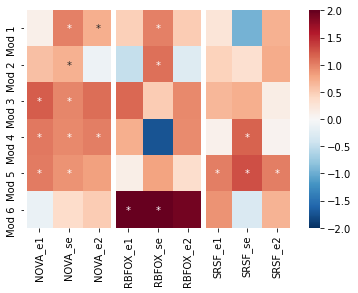

In [10]:
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [11]:
modules.loc[[x for x in modules.index if 'Srsf' in x]]

Srsf10_nmdSE_1    5
Srsf11_nmdSE_2    1
Srsf2_1           5
Srsf6_1           5
Srsf6_nmdSE_1     5
Srsf7_nmdSE_1     5
Srsf9_2           1
Srsf9_nmdSE_1     1
Srsf9_nmdSE_2     1
Name: Module, dtype: int64

In [12]:
psix_results.loc['Srsf7_nmdSE_1']

psix_score    0.056731
pvals         0.000500
qvals         0.001893
Name: Srsf7_nmdSE_1, dtype: float64

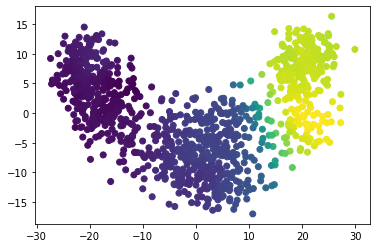

In [24]:
plt.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
            c=psix_object.adata.uns['neighbors_psi']['Clta_4'])

100%|██████████| 2087/2087 [00:12<00:00, 171.15it/s]


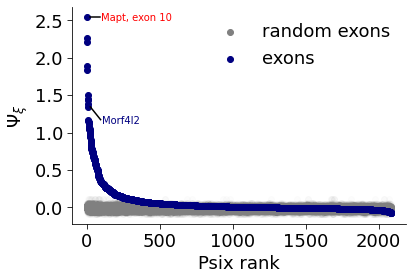

In [39]:
psix_results = psix_object.psix_results.copy()
psix_results['bins'] = ['']*2087

for mean in psix_object.bins.keys():
    for var in psix_object.bins[mean].keys():
        for exon in psix_object.bins[mean][var]:
            psix_results.loc[exon, 'bins'] = mean +'_' + var
            
fig = plt.figure()
ax  = plt.subplot(1,1,1)
i = 1

ax.scatter([100], [-0.05], c='gray', label='random exons')

for mean_var in tqdm(psix_results.sort_values('psix_score')[::-1].bins):
    mean = mean_var[:6]
    var = mean_var[7:]
    subset = np.random.choice(psix_object.random_scores[mean][var], 50, replace=False)
    ax.scatter([i]*50, subset, c='gray', alpha=0.02)
    i += 1


plt.text(100, psix_results.loc['Mapt_1'].psix_score-0.05, 'Mapt, exon 10', c='red')   
plt.plot([20, 90], [psix_results.loc['Mapt_1'].psix_score, psix_results.loc['Mapt_1'].psix_score],c='black')

plt.text(105, psix_results.loc['Morf4l2_7'].psix_score-0.22, 'Morf4l2', c='navy')   
plt.plot([25, 95], [psix_results.loc['Morf4l2_7'].psix_score, psix_results.loc['Morf4l2_7'].psix_score-0.17],c='black')

ax.scatter(np.arange(1, len(psix_results.index)+1), psix_results.sort_values('psix_score')[::-1].psix_score, c = 'navy',
          label='exons')
    
plt.xlabel('Psix rank', fontsize=18)
plt.ylabel(r'$\Psi_{\xi}$', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.legend(frameon=False, fontsize=18)

100%|██████████| 2087/2087 [00:11<00:00, 184.33it/s]


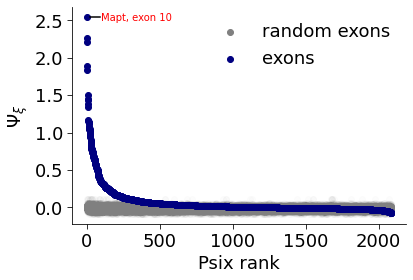

In [27]:
psix_results = psix_object.psix_results.copy()
psix_results['bins'] = ['']*2087

for mean in psix_object.bins.keys():
    for var in psix_object.bins[mean].keys():
        for exon in psix_object.bins[mean][var]:
            psix_results.loc[exon, 'bins'] = mean +'_' + var
            
fig = plt.figure()
ax  = plt.subplot(1,1,1)
i = 1

ax.scatter([100], [-0.05], c='gray', label='random exons')

for mean_var in tqdm(psix_results.sort_values('psix_score')[::-1].bins):
    mean = mean_var[:6]
    var = mean_var[7:]
    subset = np.random.choice(psix_object.random_scores[mean][var], 50, replace=False)
    ax.scatter([i]*50, subset, c='gray', alpha=0.02)
    i += 1


plt.text(100, psix_results.loc['Mapt_1'].psix_score-0.05, 'Mapt, exon 10', c='red')   
plt.plot([20, 90], [psix_results.loc['Mapt_1'].psix_score, psix_results.loc['Mapt_1'].psix_score],c='black')


ax.scatter(np.arange(1, len(psix_results.index)+1), psix_results.sort_values('psix_score')[::-1].psix_score, c = 'navy',
          label='exons')
    
plt.xlabel('Psix rank', fontsize=18)
plt.ylabel(r'$\Psi_{\xi}$', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.legend(frameon=False, fontsize=18)

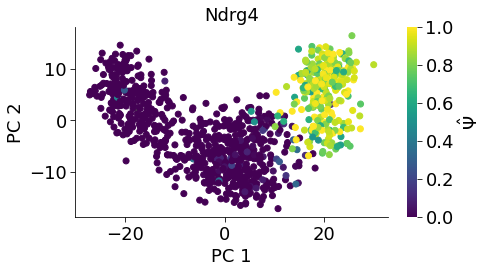

In [40]:
fig = plt.figure(figsize=(7, 3.5))
ax  = plt.subplot(1,1,1)
sc = ax.scatter(psix_object.adata.uns['latent'].PC_1, psix_object.adata.uns['latent'].PC_2, 
                c=psix_object.adata.uns['psi']['Ndrg4_1'])
# cb = plt.colorbar(sc)
ax.tick_params(labelsize=18, length=5)
cb = plt.colorbar(sc, shrink = 1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.title('Ndrg4', fontsize=18)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



In [36]:
psix_results.psix_score.sort_values()[-10:]

Morf4l2_7    1.341956
Cadm1_3      1.375236
Dst_5        1.428485
Ncam1_6      1.451343
Cadm1_10     1.503163
Gabrg2_1     1.835618
Mapt_3       1.887934
Ndrg4_1      2.214796
Dbn1_1       2.267712
Mapt_1       2.548444
Name: psix_score, dtype: float64